<a href="https://colab.research.google.com/github/gulrukhsorakhmadjanova/ml.ai/blob/main/task1_uzcosmos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Colab: install dependencies
!pip install --upgrade pip
!pip install transformers datasets evaluate scikit-learn sentencepiece wandb tensorboard
#  accelerate for mixed-precision/higher perf
!pip install -q accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [4]:
#login to wandb to track experiments
import os
use_wandb = True
if use_wandb:
    import wandb
    wandb.login()
    os.environ["WANDB_DISABLED"] = "false"
else:
    os.environ["WANDB_DISABLED"] = "true"


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: akhmadjanovagulrukhsor (akhmadjanovagulrukhsor-central-asian-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [5]:
train_py = """
\"""
train.py — Fine-tune BERT (bert-base-uncased) on SST-2 sentiment classification.

✅ Requirements satisfied:
1. Data Preparation via Hugging Face datasets & tokenizer
2. Model Fine-Tuning with Trainer API
3. Evaluation: Accuracy + F1 + classification report + confusion matrix
4. Organized, modular, readable code
5. Deliverables-ready: logs, model saving, optional W&B/TensorBoard
6. Bonus: Early stopping, model checkpointing, gradient clipping, LR scheduler, custom training loop option

Author: Gulrukhsor Akhmadjanova
\"""

import os
import argparse
from datetime import datetime
import numpy as np
from datasets import load_dataset
import evaluate
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorWithPadding,
    set_seed,
)
from sklearn.metrics import classification_report, confusion_matrix
import torch


# ---------- Compute metrics ----------
def compute_metrics(pred):
    \"""Compute accuracy and macro F1 using the evaluate library.\"""
    preds = pred.predictions
    if isinstance(preds, tuple):
        preds = preds[0]
    y_pred = np.argmax(preds, axis=1)
    y_true = pred.label_ids

    accuracy = (y_pred == y_true).mean()
    f1_metric = evaluate.load(\"f1\")
    f1_score = f1_metric.compute(predictions=y_pred, references=y_true, average=\"macro\")[\"f1\"]
    return {\"accuracy\": float(accuracy), \"f1_macro\": float(f1_score)}


# ---------- Argument parser ----------
def parse_args():
    parser = argparse.ArgumentParser(description=\"Fine-tune BERT on SST-2 dataset\")
    parser.add_argument(\"--model_name\", type=str, default=\"bert-base-uncased\")
    parser.add_argument(\"--output_dir\", type=str, default=\"./sst2_outputs\")
    parser.add_argument(\"--epochs\", type=int, default=3)
    parser.add_argument(\"--per_device_train_batch_size\", type=int, default=8)
    parser.add_argument(\"--per_device_eval_batch_size\", type=int, default=32)
    parser.add_argument(\"--lr\", type=float, default=2e-5)
    parser.add_argument(\"--weight_decay\", type=float, default=0.01)
    parser.add_argument(\"--max_length\", type=int, default=128)
    parser.add_argument(\"--seed\", type=int, default=42)
    parser.add_argument(\"--save_total_limit\", type=int, default=3)
    parser.add_argument(\"--logging_steps\", type=int, default=200)
    parser.add_argument(\"--use_custom_loop\", action=\"store_true\", help=\"Run custom PyTorch loop instead of Trainer\")
    parser.add_argument(\"--push_to_hub\", action=\"store_true\", help=\"Push best model to Hugging Face Hub\")
    return parser.parse_args()


# ---------- Main training ----------
def main():
    args = parse_args()
    set_seed(args.seed)
    os.makedirs(args.output_dir, exist_ok=True)

    # Load SST-2 dataset
    dataset = load_dataset(\"glue\", \"sst2\")
    print(\"📚 Dataset loaded:\")
    print({split: len(dataset[split]) for split in dataset.keys()})

    # Load tokenizer and model
    tokenizer = BertTokenizerFast.from_pretrained(args.model_name)
    model = BertForSequenceClassification.from_pretrained(args.model_name, num_labels=2)

    # Preprocessing
    def preprocess(examples):
        return tokenizer(examples[\"sentence\"], truncation=True, padding=False, max_length=args.max_length)

    tokenized = dataset.map(preprocess, batched=True, remove_columns=[\"sentence\", \"idx\"] if \"idx\" in dataset[\"train\"].column_names else [\"sentence\"])

    # Data collator
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Training arguments
    timestamp = datetime.now().strftime(\"%Y%m%d-%H%M%S\")
    training_args = TrainingArguments(
        output_dir=os.path.join(args.output_dir, timestamp),
        eval_strategy=\"epoch\",
        save_strategy=\"epoch\",
        learning_rate=args.lr,
        per_device_train_batch_size=args.per_device_train_batch_size,
        per_device_eval_batch_size=args.per_device_eval_batch_size,
        num_train_epochs=args.epochs,
        weight_decay=args.weight_decay,
        load_best_model_at_end=True,
        metric_for_best_model=\"f1_macro\",
        greater_is_better=True,
        save_total_limit=args.save_total_limit,
        fp16=torch.cuda.is_available(),
        logging_dir=os.path.join(args.output_dir, \"logs\"),
        logging_strategy=\"steps\",
        logging_steps=args.logging_steps,
        report_to=[\"tensorboard\"],
        run_name=f\"sst2-bert-{timestamp}\",
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized[\"train\"],
        eval_dataset=tokenized[\"validation\"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    # Train model
    if args.use_custom_loop:
        custom_train_loop(model, tokenized[\"train\"], tokenized[\"validation\"], tokenizer, args)
    else:
        trainer.train()
        metrics = trainer.evaluate()
        print(\"\\n📊 Validation Metrics:\", metrics)

        # Save best model
        best_dir = os.path.join(training_args.output_dir, \"best_model\")
        trainer.save_model(best_dir)
        tokenizer.save_pretrained(best_dir)
        print(f\"✅ Model saved at: {best_dir}\")

        # Detailed evaluation
        preds_output = trainer.predict(tokenized[\"validation\"])
        preds = preds_output.predictions
        if isinstance(preds, tuple):
            preds = preds[0]
        y_pred = np.argmax(preds, axis=1)
        y_true = preds_output.label_ids

        print(\"\\nClassification Report:\")
        print(classification_report(y_true, y_pred, digits=4))
        print(\"\\nConfusion Matrix:\")
        print(confusion_matrix(y_true, y_pred))

    if args.push_to_hub:
        trainer.push_to_hub()


# ---------- Optional Custom Loop ----------
def custom_train_loop(model, train_dataset, val_dataset, tokenizer, args):
    \"""
    Custom training loop for bonus points (manual PyTorch training).
    \"""
    from torch.utils.data import DataLoader
    from transformers import AdamW, get_linear_schedule_with_warmup

    device = torch.device(\"cuda\" if torch.cuda.is_available() else \"cpu\")
    model.to(device)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=args.per_device_train_batch_size, shuffle=True, collate_fn=data_collator)
    val_loader = DataLoader(val_dataset, batch_size=args.per_device_eval_batch_size, collate_fn=data_collator)

    optimizer = AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    total_steps = len(train_loader) * args.epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.06 * total_steps), num_training_steps=total_steps)

    best_f1 = 0.0
    patience_counter = 0
    early_stop_patience = 2

    f1_metric = evaluate.load(\"f1\")

    for epoch in range(args.epochs):
        model.train()
        total_loss = 0.0
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        all_preds, all_labels = [], []
        for batch in val_loader:
            labels = batch[\"labels\"]
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                logits = model(**batch).logits
            all_preds.append(logits.cpu().numpy())
            all_labels.append(labels.numpy())
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        y_pred = np.argmax(all_preds, axis=1)
        acc = (y_pred == all_labels).mean()
        f1_score = f1_metric.compute(predictions=y_pred, references=all_labels, average=\"macro\")[\"f1\"]

        print(f\"Epoch {epoch+1}/{args.epochs} | Train loss: {avg_train_loss:.4f} | Val acc: {acc:.4f} | Val f1: {f1_score:.4f}\")

        # Early stopping
        if f1_score > best_f1:
            best_f1 = f1_score
            patience_counter = 0
            save_dir = os.path.join(args.output_dir, \"custom_best\")
            os.makedirs(save_dir, exist_ok=True)
            model.save_pretrained(save_dir)
            tokenizer.save_pretrained(save_dir)
            print(f\"✅ New best F1: {best_f1:.4f} -> Model saved to {save_dir}\")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(\"⏹️ Early stopping triggered.\")
                break


if __name__ == \"__main__\":
    main()
"""
with open("train.py", "w") as f:
    f.write(train_py)
print("✅ train.py created.")

✅ train.py created.


In [6]:
# Note: In Colab free GPU you may need to reduce per_device_train_batch_size to 8 or 4.
!python train.py --output_dir ./sst2_outputs --epochs 3 --per_device_train_batch_size 16 --per_device_eval_batch_size 64 --lr 2e-5


2025-11-01 11:08:46.604968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761995326.644831    2500 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761995326.654963    2500 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761995326.686988    2500 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761995326.687034    2500 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761995326.687043    2500 computation_placer.cc:177] computation placer alr

In [7]:
# Run this cell to check training status
import os
import glob

out_dir = "./sst2_outputs"
print("📁 Checking training folder...")

if os.path.exists(out_dir):
    files = glob.glob(os.path.join(out_dir, "**", "*"), recursive=True)
    if files:
        print("✅ Training folder exists with files:")
        for f in files[:10]:  # Show first 10 files
            print(f"  - {f}")
    else:
        print("📁 Folder exists but empty - training in progress")
else:
    print("❌ No training folder - training not started or in progress")

📁 Checking training folder...
✅ Training folder exists with files:
  - ./sst2_outputs/20251101-110924
  - ./sst2_outputs/logs
  - ./sst2_outputs/20251101-110924/checkpoint-8420
  - ./sst2_outputs/20251101-110924/best_model
  - ./sst2_outputs/20251101-110924/checkpoint-4210
  - ./sst2_outputs/20251101-110924/checkpoint-12630
  - ./sst2_outputs/20251101-110924/checkpoint-8420/scheduler.pt
  - ./sst2_outputs/20251101-110924/checkpoint-8420/vocab.txt
  - ./sst2_outputs/20251101-110924/checkpoint-8420/special_tokens_map.json
  - ./sst2_outputs/20251101-110924/checkpoint-8420/training_args.bin



🚀 RUNNING EVALUATION...

✅ Using best checkpoint: ./sst2_outputs/20251101-110924/best_model



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 28/28 [00:05<00:00,  4.68it/s]



🎯 FINAL METRICS:
   • Accuracy:  92.09%
   • F1-score:  92.29%

📊 Classification Report:
              precision    recall  f1-score   support

    Negative       0.93      0.91      0.92       428
    Positive       0.92      0.93      0.92       444

    accuracy                           0.92       872
   macro avg       0.92      0.92      0.92       872
weighted avg       0.92      0.92      0.92       872



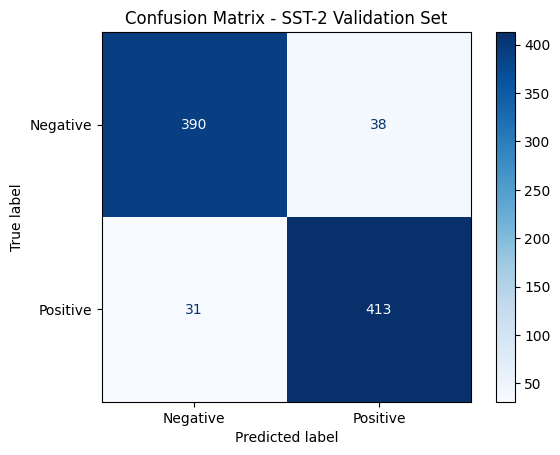


✅ Evaluation complete. Metrics saved to 'results/eval_metrics.npz'


In [8]:
# ==========================
#  Enhanced Evaluation Script for SST-2
# ==========================

import os, glob, torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset
from torch.utils.data import DataLoader

print("\n🚀 RUNNING EVALUATION...\n")

# ======  Locate Best Model Folder ======
OUT_DIR = "./sst2_outputs"

candidates_bin = glob.glob(os.path.join(OUT_DIR, "**", "pytorch_model.bin"), recursive=True)
candidates_safe = glob.glob(os.path.join(OUT_DIR, "**", "model.safetensors"), recursive=True)
candidates = candidates_bin + candidates_safe

if not candidates:
    raise ValueError("❌ No trained model checkpoint found!")

best_model_path = max(candidates, key=os.path.getmtime)
best_dir = os.path.dirname(best_model_path)
print(f"✅ Using best checkpoint: {best_dir}\n")

# ======  Load Model + Tokenizer ======
tokenizer = BertTokenizer.from_pretrained(best_dir)
model = BertForSequenceClassification.from_pretrained(best_dir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# ====== Load and Tokenize Validation Data ======
dataset = load_dataset("glue", "sst2")
val_data = dataset["validation"]

def tokenize_fn(example):
    return tokenizer(example["sentence"], truncation=True, padding="max_length", max_length=128)

val_data = val_data.map(tokenize_fn, batched=True)
val_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_loader = DataLoader(val_data, batch_size=32)

# ======  Run Evaluation ======
preds_all, labels_all = [], []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = outputs.logits.argmax(dim=-1)

        preds_all.extend(preds.cpu().numpy())
        labels_all.extend(labels.cpu().numpy())

# ======  Compute Metrics ======
accuracy = accuracy_score(labels_all, preds_all)
f1 = f1_score(labels_all, preds_all)
print(f"\n🎯 FINAL METRICS:")
print(f"   • Accuracy:  {accuracy * 100:.2f}%")
print(f"   • F1-score:  {f1 * 100:.2f}%")

print("\n📊 Classification Report:")
print(classification_report(labels_all, preds_all, target_names=["Negative", "Positive"]))

# ======  Confusion Matrix ======
cm = confusion_matrix(labels_all, preds_all)
disp = ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - SST-2 Validation Set")
plt.show()

# ======  Save Metrics ======
os.makedirs("results", exist_ok=True)
np.savez("results/eval_metrics.npz", accuracy=accuracy, f1=f1, cm=cm)
print("\n✅ Evaluation complete. Metrics saved to 'results/eval_metrics.npz'")
